In [11]:
from fastai import *
from fastai.vision import *
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.learner import cnn_config
from fastai.callbacks import *
import sys
sys.path.append('../../')
sys.path.append('../../model')
from model.losses import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

In [12]:
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)

# old model loading

In [3]:
mf_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/')

In [11]:
mf = load_learner(path=mf_pth, file='mitotracker_PSSR-MF_512.pkl')

/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'fastai.vision.models.unet.DynamicUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original so

### pour out state dict

In [13]:
mf.model

BilinearWrapper(
  (model): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Sequential(
          (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
        )
        (2): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
        )
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): ResBlock(
            (convs): Sequential(
              (0): Sequential(
                (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): ReLU(inplace=True)
              )
              (1): Sequential(
                (0): Conv2d(64, 64, kernel_size=(3, 3

In [16]:
old_dict = mf.model.state_dict()

In [17]:
old_dict

OrderedDict([('model.layers.0.0.0.weight_g', tensor([[[[0.5024]]],
              
              
                      [[[0.5146]]],
              
              
                      [[[0.5747]]],
              
              
                      [[[0.6675]]],
              
              
                      [[[0.6250]]],
              
              
                      [[[0.5894]]],
              
              
                      [[[0.5132]]],
              
              
                      [[[0.4937]]],
              
              
                      [[[0.5898]]],
              
              
                      [[[0.5928]]],
              
              
                      [[[0.6084]]],
              
              
                      [[[0.5815]]],
              
              
                      [[[0.5522]]],
              
              
                      [[[0.5303]]],
              
              
                      [[[0.6206]]],
         

In [18]:
torch.save(old_dict, mf_pth/'baselines/mitotracker_PSSR-MF_512_state_dict.pkl')

# load the state dict

In [25]:
new_dict = torch.load(mf_pth/'baselines/mitotracker_PSSR-MF_512_state_dict.pkl')

### data load

In [13]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')

In [14]:
bs=8
lr = slice(None, 4e-4, None)
size=512 
tile_sz=512 
# datasetname=multi_100mitotracker 
cycles=100
# save_name=multit_5_100mito_opt_001 
n_frames=5

In [15]:
lr_type = 't'
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [16]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [17]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


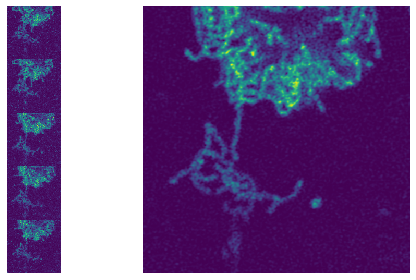

In [8]:
data.show_batch(rows=1)

### initiate learner

In [19]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

In [23]:
# feat loss just to play safe
critic_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/')
critic = load_learner(path=critic_pth/'critics',file='critic_fluorescence_single.2a.pkl')
encoder = critic.model.eval()[0]
feature_maps = find_layers(flatten_model(encoder))
feat_loss = FeatureLoss(m_feat=encoder, layer_wgts=[1/7 for _ in range(7)])

In [24]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                           loss_func=feat_loss, metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)

In [26]:
learn.model.load_state_dict(new_dict)

<All keys matched successfully>

In [27]:
learn.validate()

[1.2958254, tensor(28.1936), tensor(0.2601)]

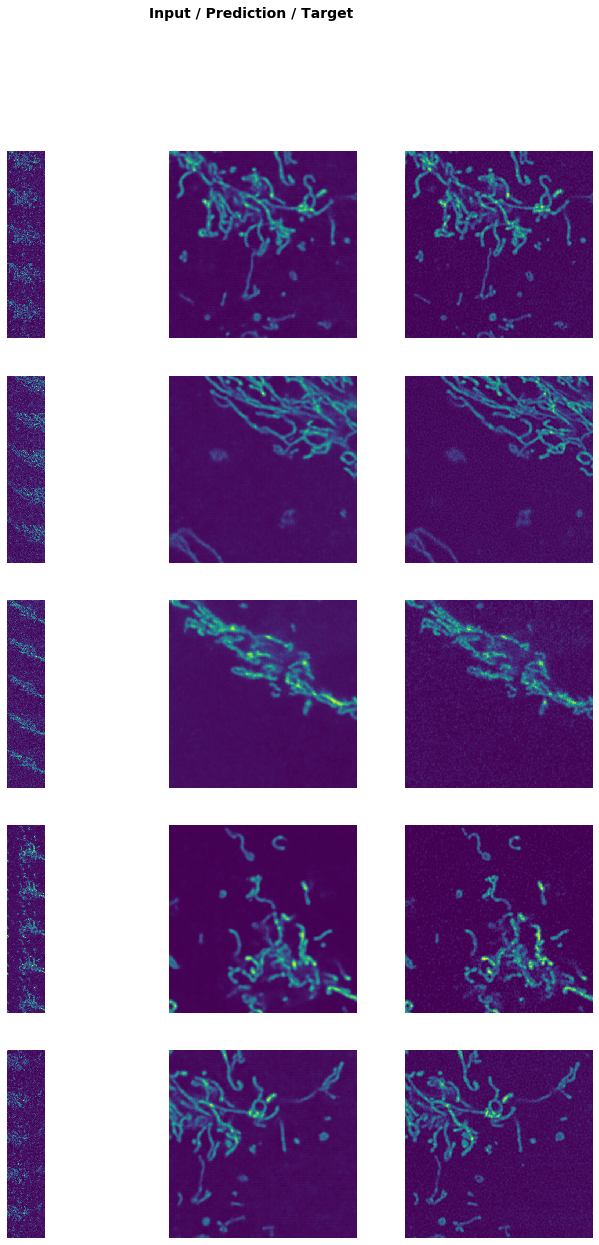

In [28]:
learn.show_results()

# export

In [31]:
learn.path = mf_pth/'baselines/'; learn.path

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/baselines')

In [32]:
learn.export(file='mitotracker_PSSR-MF_512.pkl')

# Lj & ours

In [7]:
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models')
state_dict = torch.load(model_pth/'feat_loss'/'sf_state_dict.pkl')

In [55]:
model_name = 'mitotracker_PSSR-MF_512'
learn_lj = load_learner(path=learn_lj_pth/'baselines', file=f'{model_name}.pkl')
# learn_lj.model.load_state_dict(state_dict)

In [61]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                         metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)
# learn.model.load_state_dict(state_dict)

In [69]:
xb, yb = learn.data.one_batch()

In [71]:
yb.shape

torch.Size([8, 1, 512, 512])

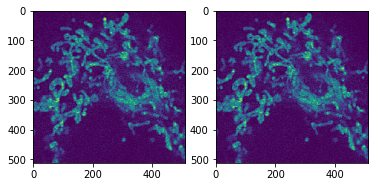

In [80]:
plt.subplot(1, 2, 1)
plt.imshow(learn.data.single_ds.y.reconstruct(t=yb[0]).data[0])
plt.subplot(1, 2, 2)
plt.imshow(learn_lj.data.single_ds.y.reconstruct(t=yb[0]).data[0])
plt.show()

In [76]:
import matplotlib.pyplot as plt

In [34]:
set(lj_dict.keys()).difference(set(our_dict.keys()))

set()

In [42]:
learn_lj.data.single_ds??